<a id="t1."></a>
# 1. Import data and python packages

In [70]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [71]:
# Define paths
train_directory = Path("../Beef1/Meat/train")
test_directory = Path("../Beef1/Meat/test")
valid_directory = Path("../Beef1/Meat/valid")

In [72]:
# Set the desired sample size
sample_size = 1033

# Set the desired width and height for resizing images
width = 224 
height = 224

In [73]:
files = ['Fresh', 'Melted']

def load_images(directory, files, sample_size):
    data = {}
    for f in files:
        data[f] = []

    for col in files:
        dir_path = directory / col
        image_files = [file for file in os.listdir(dir_path) if file.endswith('.jpg')]
        
        # Use all images if fewer than sample_size
        if len(image_files) < sample_size:
            selected_files = image_files
        else:
            selected_files = np.random.choice(image_files, sample_size, replace=False)
        
        for file in selected_files:
            data[col].append(os.path.join(dir_path, file))

    image_data = []
    image_target = []

    for title in files:
        for file in data[title]:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (width, height))
            image_data.append(img_resized)
            image_target.append(title)
    
    return np.array(image_data), np.array(image_target)

# Load and preprocess training data
image_train_data, image_train_target = load_images(train_directory, files, sample_size)
image_test_data, image_test_target = load_images(test_directory, files, sample_size)
image_valid_data, image_valid_target = load_images(valid_directory, files, sample_size)

In [74]:
# Verify loaded data
print(f"Training data shape: {image_train_data.shape}")
print(f"Training labels shape: {image_train_target.shape}")
print(f"Test data shape: {image_test_data.shape}")
print(f"Test labels shape: {image_test_target.shape}")
print(f"Validation data shape: {image_valid_data.shape}")
print(f"Validation labels shape: {image_valid_target.shape}")

Training data shape: (2066, 224, 224, 3)
Training labels shape: (2066,)
Test data shape: (464, 224, 224, 3)
Test labels shape: (464,)
Validation data shape: (464, 224, 224, 3)
Validation labels shape: (464,)


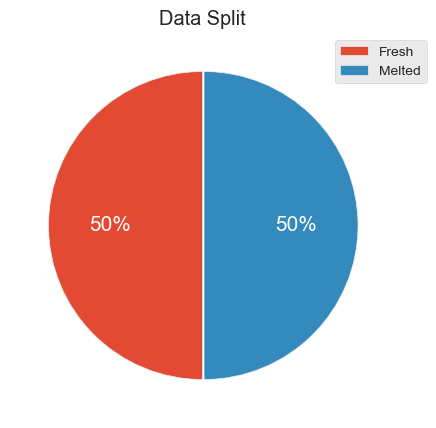

In [75]:
# Plot the data distribution
sizes = [len(image_train_target[image_train_target == 'Fresh']), len(image_train_target[image_train_target == 'Melted'])]

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color':"w", "fontsize":15}, startangle=90, explode=(0, .01))
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

<a id="t2."></a>
# 2. Data visualization

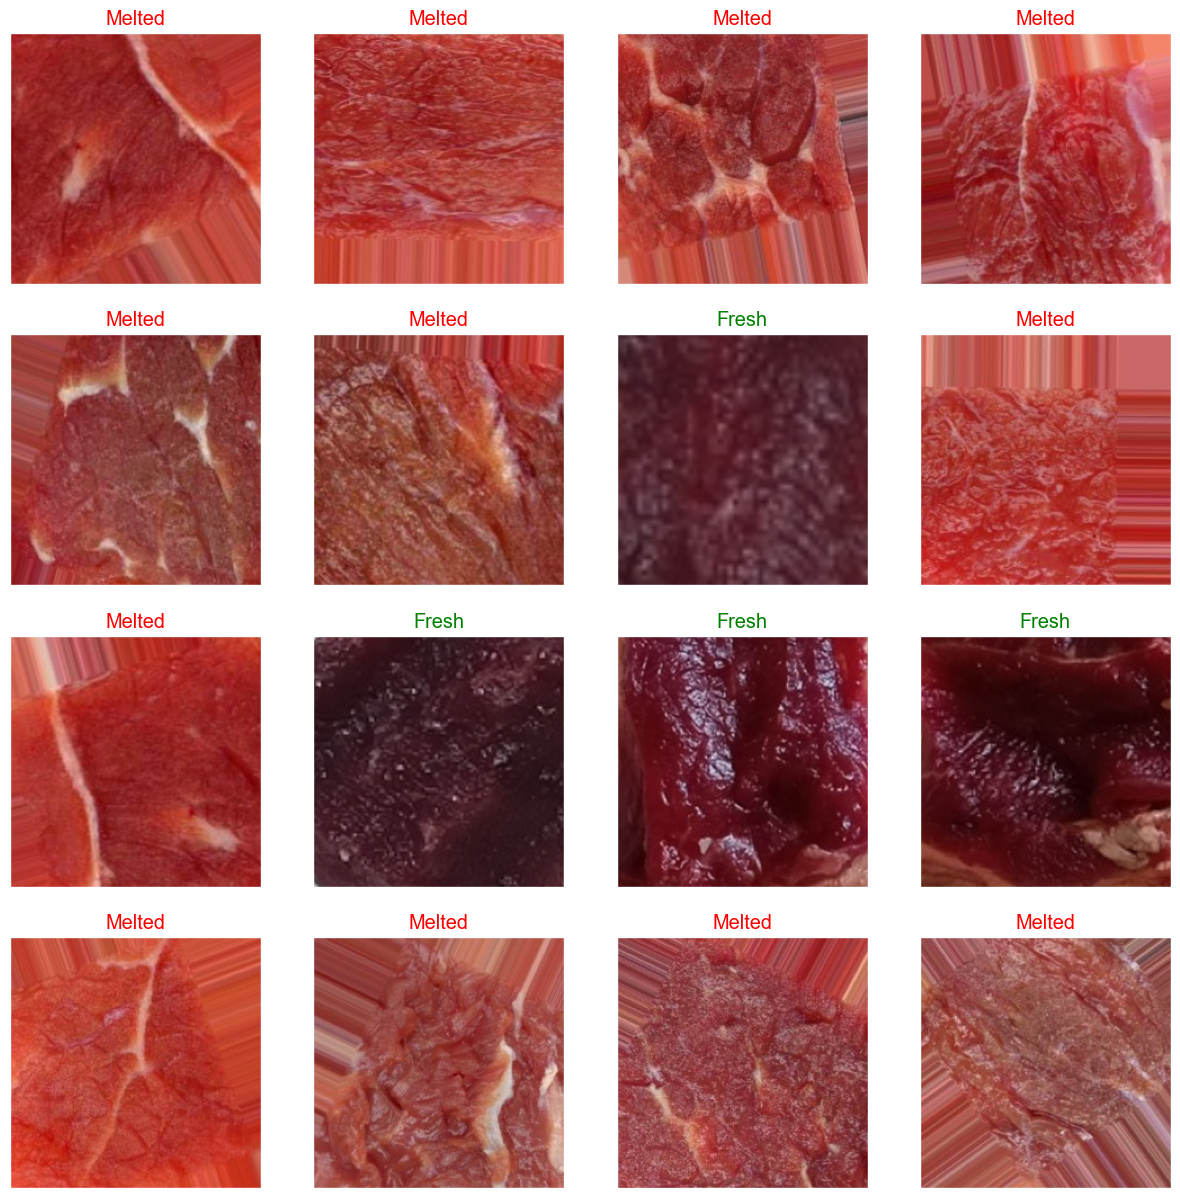

In [76]:
# Define size_train to be the length of image_train_data
size_train = len(image_train_data)

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.randint(size_train)
    plt.subplot(4, 4, i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig] == 'Fresh':
        c = 'green'
    else:
        c = 'red'
    plt.title(image_train_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

<a id="t3."></a>
# 3. Classification (CNN)

In [77]:
from sklearn.preprocessing import LabelEncoder

In [78]:
labels = LabelEncoder()
labels.fit(image_train_target)

LabelEncoder()

In [79]:
# Normalize the images
X_train = image_train_data / 255.0
X_test = image_test_data / 255.0
X_valid = image_valid_data / 255.0

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(image_train_target)
y_test = label_encoder.transform(image_test_target)
y_valid = label_encoder.transform(image_valid_target)

In [80]:


# train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.15, random_state=123)

# #Bagi data menjadi set pelatihan (70%) dan set sementara (30%)
# train_images, temp_images, train_labels, temp_labels = train_test_split(X, y, test_size=0.30, random_state=123)
# 
# #Bagi set sementara menjadi set validasi (15%) dan set pengujian (15%)
# validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.50, random_state=123)

# Memeriksa ukuran set
print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_valid.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

Train set size: 2066
Validation set size: 464
Test set size: 464


In [81]:
# Assuming y_train and y_valid are integer labels (e.g., 0 or 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=2)

In [82]:
# train_images, train_labels = X , y
# test_images , test_labels = tX, ty

In [83]:
# Membuat model Sequential
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [84]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_16 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 111, 111, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 32)      4640      
                                                      

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Call_Back = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model-2.h5', monitor='val_loss', save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
            print("\nReached or Exceed 99.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [87]:
# from sklearn.preprocessing import LabelEncoder

# # Convert train_labels and test_labels to integers using LabelEncoder
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    verbose=1,
    callbacks=[Call_Back, callback]
)


Epoch 1/20
65/65 [==============================] - 24s 339ms/step - loss: 0.2860 - accuracy: 0.9806 - val_loss: 2.7404 - val_accuracy: 0.5065
Epoch 2/20
65/65 [==============================] - 21s 324ms/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 0.7383 - val_accuracy: 0.6918
Epoch 3/20
65/65 [==============================] - 20s 308ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.5547 - val_accuracy: 0.8039
Epoch 4/20
65/65 [==============================] - 18s 284ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.2847 - val_accuracy: 0.9461
Epoch 5/20
65/65 [==============================] - 19s 290ms/step - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0955 - val_accuracy: 0.9763
Epoch 6/20
65/65 [==============================] - 19s 286ms/step - loss: 0.0374 - accuracy: 0.9952 - val_loss: 0.2580 - val_accuracy: 0.9763
Epoch 7/20
65/65 [==============================] - 19s 296ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.5462 - val_accuracy: 0.9784

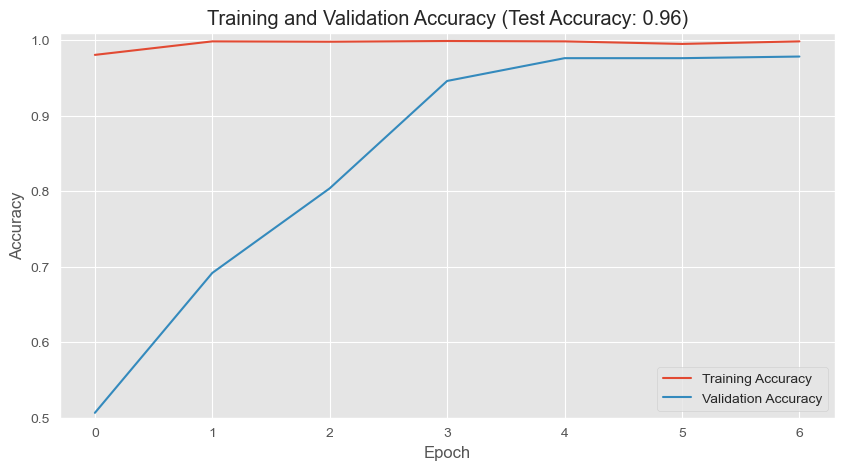

In [88]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Include test accuracy in the plot title
plt.title(f'Training and Validation Accuracy (Test Accuracy: {test_acc:.2f})')
plt.show()

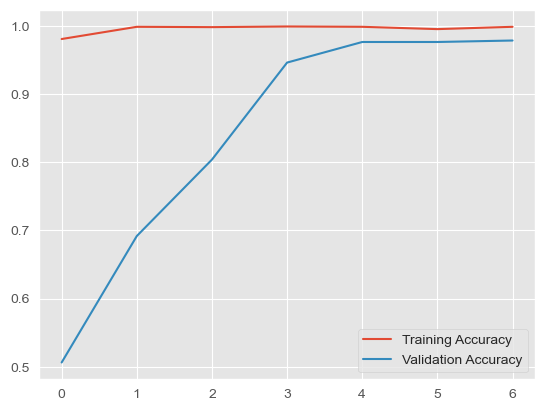

In [89]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [90]:
result=model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 87ms/step - loss: 0.8923 - accuracy: 0.9612


<a id="t4."></a>
# 4. Prediction

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [92]:
# Convert one-hot encoded y_valid to binary format
y_valid_binary = np.argmax(y_valid, axis=1)

# Predict on validation data
y_val_pred = model.predict(X_valid)

# Function to convert predictions to class labels
def toClass(pred):
    return np.argmax(pred, axis=1)

# Convert predictions to binary format
y_val_pred_binary = toClass(y_val_pred)

# Generate confusion matrix
cm_val = confusion_matrix(y_valid_binary, y_val_pred_binary)

# Create a DataFrame for better visualization
df_val = pd.DataFrame(cm_val, index=["Fresh", "Melted"], columns=["Fresh", "Melted"])

# Plotting the confusion matrix
f_val, ax_val = plt.subplots(figsize=(6, 6))
sns.heatmap(df_val, annot=True, cmap="Greens", fmt='.0f', ax=ax_val, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix", size=12)
plt.show()

15/15 [==============================] - 1s 84ms/step


15/15 [==============================] - 1s 86ms/step


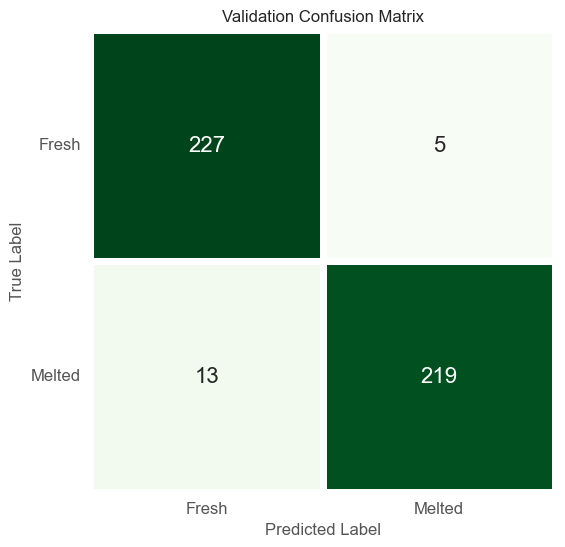

In [93]:
# Convert one-hot encoded y_valid to binary format
y_train_binary = np.argmax(y_test, axis=1)

# Predict on validation data
y_train_pred = model.predict(X_test)

# Function to convert predictions to class labels
def toClass(pred):
    return np.argmax(pred, axis=1)

# Convert predictions to binary format
y_train_pred_binary = toClass(y_train_pred)

# Generate confusion matrix
cm_val = confusion_matrix(y_train_binary, y_train_pred_binary)

# Create a DataFrame for better visualization
df_val = pd.DataFrame(cm_val, index=["Fresh", "Melted"], columns=["Fresh", "Melted"])

# Plotting the confusion matrix
f_val, ax_val = plt.subplots(figsize=(6, 6))
sns.heatmap(df_val, annot=True, cmap="Greens", fmt='.0f', ax=ax_val, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix", size=12)
plt.show()

In [94]:
from sklearn.metrics import classification_report

# Assuming y_test is one-hot encoded, convert it to binary class labels
y_test_binary = np.argmax(y_test, axis=1)

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_class = toClass(y_pred)

# Define target names
target_names = ["Fresh", "Melted"]

# Generate classification report
report = classification_report(y_test_binary, y_pred_class, target_names=target_names)

# Display classification report
print("Classification Report:")
print(report)


15/15 [==============================] - 1s 91ms/step
Classification Report:
              precision    recall  f1-score   support

       Fresh       0.95      0.98      0.96       232
      Melted       0.98      0.94      0.96       232

    accuracy                           0.96       464
   macro avg       0.96      0.96      0.96       464
weighted avg       0.96      0.96      0.96       464


In [95]:
def prediction(image):
    
    global width, height, files, labels
    
    img = cv2.resize(image,(width,height))
    
    test = img / 255.0
    
    pred = model.predict(np.array([image])).argmax()
    
    return labels.inverse_transform([pred])[0]

1/1 [==============================] - 0s 26ms/step


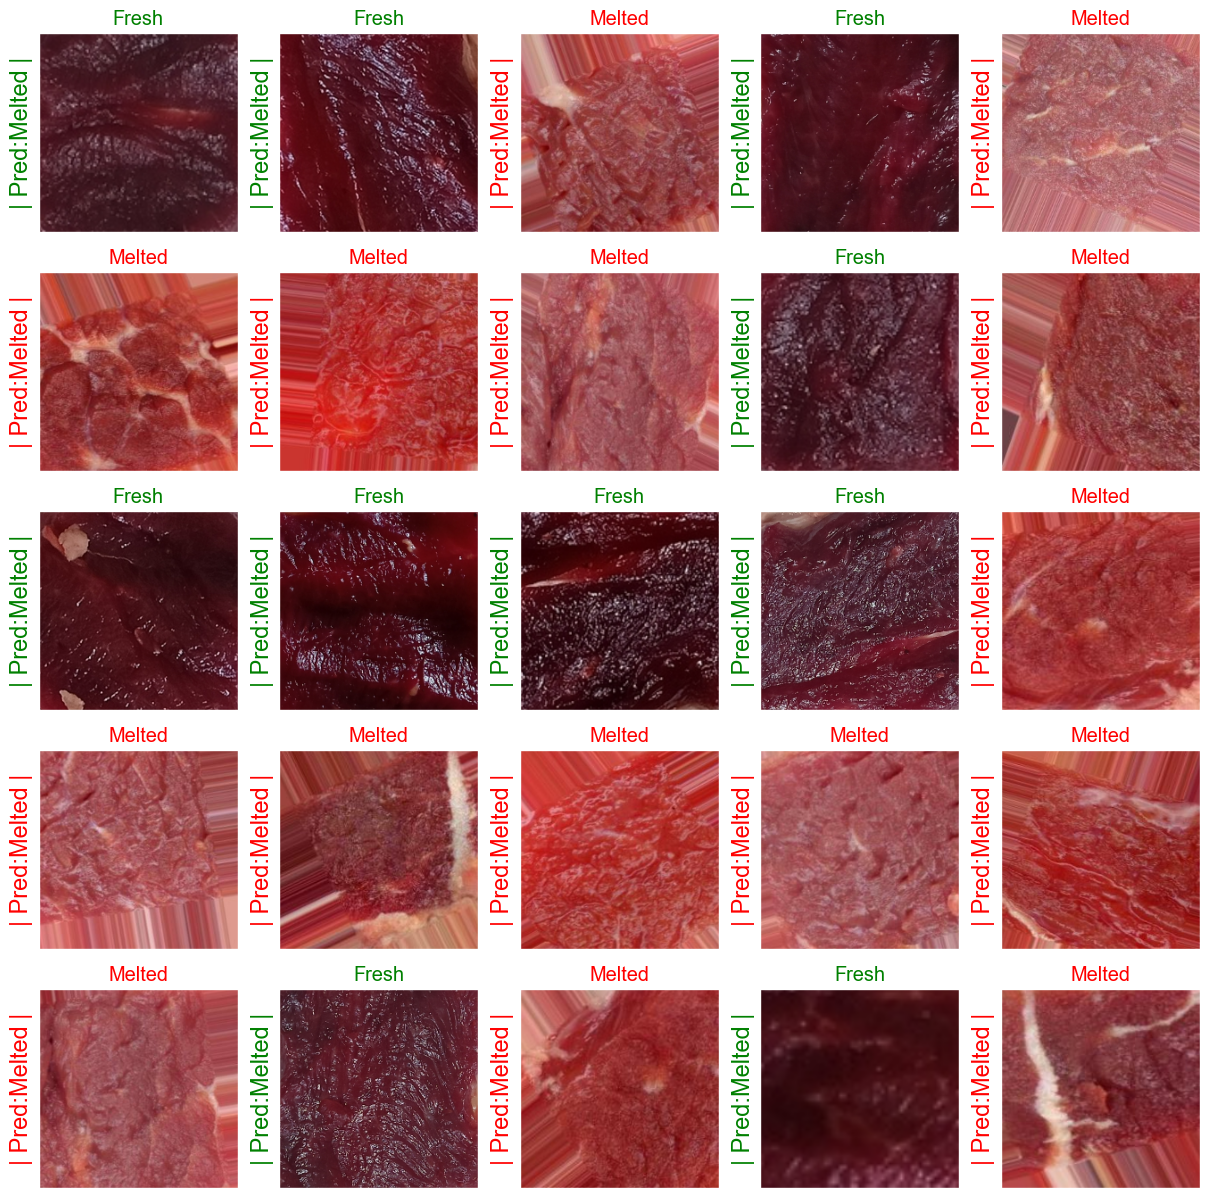

In [96]:
plt.figure(figsize=(15,15))
for i in range(1,26):
    fig = np.random.choice(np.arange(size_train))
    plt.subplot(5,5,i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig]=='Fresh':
        c='green'
    else:
        c='red'
    plt.title(image_train_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(prediction(image_train_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()